In [1]:
from deeprpi.utils import RPIDataset
from deeprpi.model.embedding import ProteinFeatureExtractor, load_esm
from deeprpi.utils.plot import ContactMapVisualizer
from deeprpi.config.glob import AMINO_ACIDS

In [2]:
RPIDataset = RPIDataset(data_path='./data/NPInter5.csv',
                            batch_size=32,
                            num_workers=4,
                            rna_col='RNA_aa_code',
                            protein_col='target_aa_code',
                            label_col='Y',
                            padding=True,
                            rna_max_length=1000,
                            protein_max_length=1000,
                            truncation=False,
                            val_ratio=0.1,
                            test_ratio=0.1)

In [3]:
RPIDataset.setup()
train_dataloader = RPIDataset.train_dataloader()

Selecting data: 100%|██████████| 1182/1182 [00:00<00:00, 885614.03it/s]


Selected 313 samples from 1182 samples


Padding protein sequences: 100%|██████████| 313/313 [00:00<00:00, 77884.26it/s]


In [4]:
model, alphabet = load_esm()
extractor = ProteinFeatureExtractor(model= model, alphabet=alphabet)
for batch in train_dataloader:
    protein_tokens = batch[2]
    break

Model loaded successfully.


In [5]:
embeddings, contacts, lengths = extractor(protein_tokens[0:2], 'token')

测试token-level的输出

嵌入形状: torch.Size([2, 328, 1280])
接触图形状: torch.Size([326, 326])


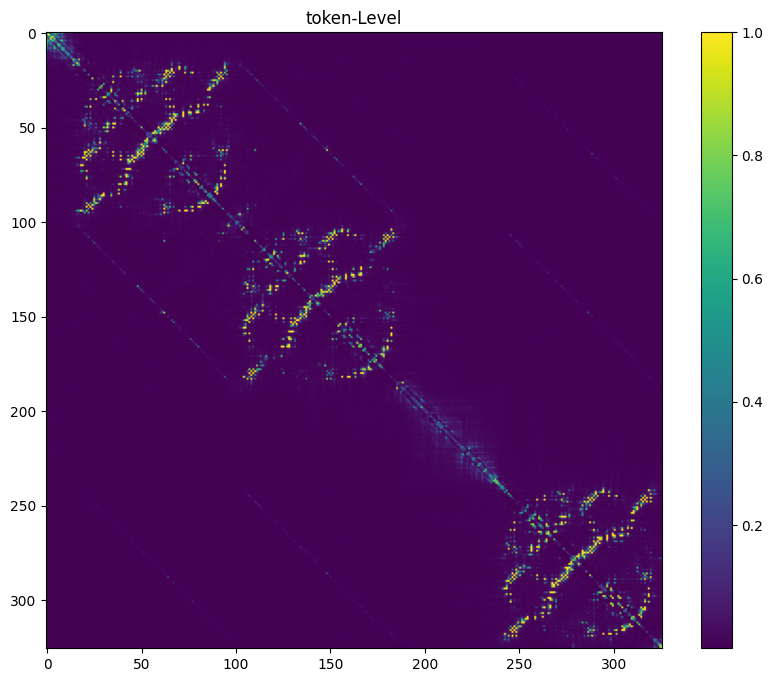

In [6]:
print(f"嵌入形状: {embeddings.shape}")
print(f"接触图形状: {contacts[0].shape}")
ContactMapVisualizer.plot_contact_map(
    contacts[0].cpu().numpy(),
    title="token-Level"
)

测试sequence-level的输出

In [7]:
seq_embeddings, contact_stats, _ = extractor(protein_tokens[0:2], 'sequence')
print("Sequence-Level:")
print(f"嵌入形状: {seq_embeddings.shape}")
print(f"接触统计: {contact_stats[0]}")

Sequence-Level:
嵌入形状: torch.Size([2, 1280])
接触统计: {'global_density': 0.019041642546653748, 'local_density': 0.12922640144824982}


手工输入一个序列进行测试，检查模型数据的合理性与输出的维度，结果发现：<br>全局接触密度和局部接触密度均小于实验值，但是两者比值与实验值之间的比值接近，用于下游任务应该问题不大

In [8]:
test_sequence = "MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV"
bos = AMINO_ACIDS['<bos>']  # 序列起始标记
eos = AMINO_ACIDS['<eos>']  # 序列结束标记
encoded_seq = [bos] + [AMINO_ACIDS[aa] for aa in test_sequence] + [eos]
pooled_emb, contact_stats, _ = extractor([encoded_seq], 'sequence')
print(f"嵌入向量形状: {pooled_emb.shape}")
print(f"接触统计: {contact_stats[0]}\n")
token_emb, contact_maps, lengths = extractor([encoded_seq], 'token')
print(f"Token嵌入形状: {token_emb.shape}")
print(f"接触图形状: {contact_maps[0].shape}")

嵌入向量形状: torch.Size([1, 1280])
接触统计: {'global_density': 0.019998347386717796, 'local_density': 0.10442353039979935}

Token嵌入形状: torch.Size([1, 150, 1280])
接触图形状: torch.Size([148, 148])
